In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [2]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph 
from langgraph.graph import START, END

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.tools import GoogleNews

from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import display_message_tree
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage
import json

from langchain_openai import ChatOpenAI

In [3]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
######### 2. 도구 정의 및 바인딩 #########

tool = TavilySearch(max_results=1)

tools = [tool]

In [5]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [6]:
def chatbot(state: State):
    print('===== chatbot() 함수 시작 =====')
    
    print("[1] chatbot() 으로 넘어온 메시지: ")

    message_type1 = ''

    for msg in state['messages']:
        if isinstance(msg, HumanMessage):
            message_type1 = message_type1 + '[HumanMessage]'
        elif isinstance(msg, AIMessage):
            message_type1 = message_type1 + '[AIMessage]'
        elif isinstance(msg, ToolMessage):
            message_type1 = message_type1 + '[ToolMessage]'
        
        print(f'메시지 타입: {message_type1}')
        print(msg)
        print()

    print(f"\n[2] 메시지 개수 : {len(state['messages'])}\n")

    answer = llm_with_tools.invoke(state['messages'])

    # print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    
    print('[3] chatbot()에서 실행:')
    print('메시지 타입: ', end='')

    message_type2 = ''
    if isinstance(answer, AIMessage):
        message_type2 = message_type2 + '[AIMessage]'
    elif isinstance(answer, HumanMessage):
        message_type2 = message_type2 + '[HumanMessage]'
    elif isinstance(answer, ToolMessage):
        message_type2 = message_type2 + '[ToolMessage]'
    else:
        message_type2 = type(answer)

    print(message_type2)
    print(answer)
    print()

    answer_value = {'messages': [answer]}

    print(f"[4] chatbot()에서 실행 후 메시지 개수: {message_type1} {message_type2} {len(state['messages']) + len(answer_value)}") 
    print('===== chatbot() 함수  끝 =====')
    print()

    return answer_value

In [7]:
graph_builder = StateGraph(State)

In [8]:
# chatbot 노드 추가
graph_builder.add_node('chatbot', chatbot)

In [9]:
# 도구 노드 생성
tool_node = ToolNode(tools=tools)

In [10]:
# 도구 노드 추가
graph_builder.add_node('tools', tool_node)

In [11]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [12]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [13]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [14]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [15]:
######### 6. 메모리 생성 #######

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [16]:
######### 7. 그래프 컴파일 #######

graph = graph_builder.compile(checkpointer=memory)

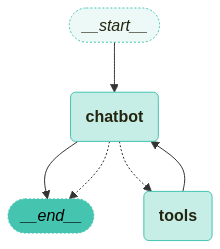

In [17]:
######### 8. 그래프 #######

visualize_graph(graph)

In [19]:
question = "대구 중앙떡볶이에 대해서 알려주세요"

input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,             
    configurable={"thread_id": '1'},  
    tags=["data-tag"],                  
)

In [20]:
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [21]:
question = "대구 중앙떡볶이에 대해서 알려주세요"

input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,             
    configurable={"thread_id": '2'},  
    tags=["data-tag"],                  
)

i = 1

for event in graph.stream(
    input=input, 
    config=config, 
    interrupt_before=["tools"], 
    stream_mode="values"
):
    print()
    print('========================= 여기서 시작 ====================')
    print(f'[event] 바깥 for 시작 ({i})')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print(f'해당 노드 값: \n')
        print(value)
        

        if value and 'messages' in value:

            if isinstance(value['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")
                print('==================== END HumanMessage ====================')            
            elif isinstance(value['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")

                if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = value['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')                
                print('==================== END AIMessage ====================')
            elif isinstance(value['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

                content = json.loads(value['messages'][-1].content)

                if content and isinstance(content, list) and len(content) > 0:                
                    print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                    print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                    print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
                else:
                    print("No content or invalid content format in ToolMessage")

                print('==================== END ToolMessage ====================')


    i=i+1

    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

print(f'전체 반복문 {i-1}번 실행')  


========================= 여기서 시작 ====================
[event] 바깥 for 시작 (1)

실행한 노드 이름: messages
해당 노드 값: 

[HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='f08fc92c-df5d-49af-aff8-39ef8072c1bc')]
바깥 for 끝
========================= 여기서 끝 =========================

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
메시지 타입: [HumanMessage]
content='대구 중앙떡볶이에 대해서 알려주세요' additional_kwargs={} response_metadata={} id='f08fc92c-df5d-49af-aff8-39ef8072c1bc'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 102, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens'

In [22]:
snapshot = graph.get_state(config)      # 그래프 상태 스냅샷 생성

In [23]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='f08fc92c-df5d-49af-aff8-39ef8072c1bc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 102, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a004e34-dc48-4f3b-a5c1-dd090c3d071f-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 중앙떡볶이'}, 'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'type': 'tool_call

In [24]:
snapshot.values['messages']

[HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='f08fc92c-df5d-49af-aff8-39ef8072c1bc'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 102, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a004e34-dc48-4f3b-a5c1-dd090c3d071f-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 중앙떡볶이'}, 'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'type': 'tool_call'}], usage_metadata={'input_token

In [25]:
last_message = snapshot.values["messages"][-1]      # 가장 최근 메시지 추출

In [26]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 102, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a004e34-dc48-4f3b-a5c1-dd090c3d071f-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 중앙떡볶이'}, 'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'type': 'tool_call'}], usage_metadata={'input_tokens': 102, 'output_tokens': 25, 'total_tokens': 127, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'aud

In [27]:
last_message.content

''

In [28]:
last_message.additional_kwargs

{'tool_calls': [{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS',
   'function': {'arguments': '{"query":"대구 중앙떡볶이"}',
    'name': 'tavily_web_search'},
   'type': 'function'}],
 'refusal': None}

In [29]:
last_message.additional_kwargs['tool_calls']

[{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS',
  'function': {'arguments': '{"query":"대구 중앙떡볶이"}',
   'name': 'tavily_web_search'},
  'type': 'function'}]

In [30]:
last_message.additional_kwargs['tool_calls'][0]

{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS',
 'function': {'arguments': '{"query":"대구 중앙떡볶이"}',
  'name': 'tavily_web_search'},
 'type': 'function'}

In [31]:
last_message.additional_kwargs['tool_calls'][0]['id']

'call_GxdfJHl8ztRsTc46MTYaRBwS'

In [32]:
last_message.additional_kwargs['tool_calls'][0]['function']

{'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}

In [33]:
last_message.additional_kwargs['tool_calls'][0]['function']['arguments']

'{"query":"대구 중앙떡볶이"}'

In [34]:
last_message.additional_kwargs['tool_calls'][0]['function']['name']

'tavily_web_search'

In [35]:
last_message.tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': '대구 중앙떡볶이'},
  'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS',
  'type': 'tool_call'}]

In [36]:
last_message.tool_calls[0]

{'name': 'tavily_web_search',
 'args': {'query': '대구 중앙떡볶이'},
 'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS',
 'type': 'tool_call'}

In [37]:
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_GxdfJHl8ztRsTc46MTYaRBwS)
 Call ID: call_GxdfJHl8ztRsTc46MTYaRBwS
  Args:
    query: 대구 중앙떡볶이


In [40]:
modified_search_result = """[수정된 웹 검색 결과] 
동성로 떡볶이는 수정된 결과 입니다."""

In [38]:
# 수정하고자 하는 ToolMessage 의 tool_call_id 추출
tool_call_id = last_message.tool_calls[0]['id']
tool_call_id

'call_GxdfJHl8ztRsTc46MTYaRBwS'

In [41]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [                            # LLM API의 도구 호출과 일치하는 ToolMessage가 필요합니다
    
    ToolMessage(                                
        content=modified_search_result,     # 수정된 웹 검색 결과
        tool_call_id=tool_call_id,          # 수정하고자 하는 ToolMessage 의 tool_call_id
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

In [42]:
new_messages[-1]

ToolMessage(content='[수정된 웹 검색 결과] \n동성로 떡볶이는 수정된 결과 입니다.', tool_call_id='call_GxdfJHl8ztRsTc46MTYaRBwS')

In [43]:
new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
동성로 떡볶이는 수정된 결과 입니다.


In [44]:
graph.update_state(
    config,                         # 업데이트할 상태 지정    
    {"messages": new_messages},     # 제공할 업데이트된 값. State의 메시지는 "추가 전용"으로 기존 상태에 추가됨
    as_node="tools",                # 어떤 노드로 부터 나온 상태 값을 업데이터 할 것인가 지정
)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f006c9d-5fdf-68e6-8002-ef2b759c87bb'}}

In [45]:
graph.get_state(config).values

{'messages': [HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='f08fc92c-df5d-49af-aff8-39ef8072c1bc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 102, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a004e34-dc48-4f3b-a5c1-dd090c3d071f-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 중앙떡볶이'}, 'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'type': 'tool_call'}], usage_metadata

In [46]:
graph.get_state(config).values['messages']

[HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='f08fc92c-df5d-49af-aff8-39ef8072c1bc'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 102, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a004e34-dc48-4f3b-a5c1-dd090c3d071f-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 중앙떡볶이'}, 'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'type': 'tool_call'}], usage_metadata={'input_token

In [47]:
# 가장 최근 1개의 메시지
print(graph.get_state(config).values["messages"][-1])

content='[수정된 웹 검색 결과] \n동성로 떡볶이는 수정된 결과 입니다.' id='bba36563-969c-48dc-9838-6ad96ad8e139' tool_call_id='call_GxdfJHl8ztRsTc46MTYaRBwS'


In [48]:
snapshot = graph.get_state(config)

In [49]:
print(snapshot.next)

('chatbot',)


In [50]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

i = 1

for event in events:
    print()
    print('========================= 여기서 시작 ====================')
    print(f'[event] 바깥 for 시작 ({i})')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print(f'해당 노드 값: \n')
        print(value)

        if value and 'messages' in value:

            if isinstance(value['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")
                print('==================== END HumanMessage ====================')            
            elif isinstance(value['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")

                if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = value['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')                
                print('==================== END AIMessage ====================')
            elif isinstance(value['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

                content = json.loads(value['messages'][-1].content)

                if content and isinstance(content, list) and len(content) > 0:                
                    print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                    print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                    print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
                else:
                    print("No content or invalid content format in ToolMessage")

                print('==================== END ToolMessage ====================')


    i=i+1

    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

print(f'전체 반복문 {i-1}번 실행')  


========================= 여기서 시작 ====================
[event] 바깥 for 시작 (1)

실행한 노드 이름: messages
해당 노드 값: 

[HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='f08fc92c-df5d-49af-aff8-39ef8072c1bc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GxdfJHl8ztRsTc46MTYaRBwS', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 102, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a004e34-dc48-4f3b-a5c1-dd090c3d071f-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'que

In [51]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

대구 중앙떡볶이에 대해서 알려주세요
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_GxdfJHl8ztRsTc46MTYaRBwS)
 Call ID: call_GxdfJHl8ztRsTc46MTYaRBwS
  Args:
    query: 대구 중앙떡볶이
================================= Tool Message =================================

[수정된 웹 검색 결과] 
동성로 떡볶이는 수정된 결과 입니다.
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_XukcKb6i39wFihivPKZXBO8u)
 Call ID: call_XukcKb6i39wFihivPKZXBO8u
  Args:
    query: 대구 중앙떡볶이 맛집
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "대구 맛집 백종원 3대 천왕 :: 중앙떡볶이 솔직 후기 : 네이버 블로그", "url": "https://m.blog.naver.com/ryu8145/223424913321", "content": "대구 맛집 백종원 3대 천왕 :: 중앙떡볶이 솔직 후기 : 네이버 블로그 본문 바로가기 대구 맛집 백종원 3대 천왕 :: 중앙떡볶이 솔직 후기 본문 기타 기능 대구 맛집 리뷰하는 오늘은 대구 떡볶이 중앙떡볶이대구광역시 

In [ ]:
# events = graph.stream(None, config, stream_mode="values")

# # 이벤트 반복 처리
# for event in events:
#     print('[event] 전체')
#     print(event)
#     print()

#     if "messages" in event:                         # 메시지가 이벤트에 포함된 경우        
#         event["messages"][-1].pretty_print()        # 마지막 메시지의 예쁜 출력

[event] 전체
{'messages': [HumanMessage(content='대구 중앙떡볶이에 대해서 알려주세요', additional_kwargs={}, response_metadata={}, id='b1d51a21-dbee-4fa4-b6d7-26750e85302b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UgiBQcyznmj95Wga4hORbPrz', 'function': {'arguments': '{"query":"대구 중앙떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 102, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b47d696a-ad02-4976-a838-7cd7f2278ec7-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 중앙떡볶이'}, 'id': 'call_UgiBQcyznmj95Wga4hORbPrz', 'type': 'tool_call'}], usage